find the chessboard corners of data\0000.jpg
find the chessboard corners of data\0001.jpg
find the chessboard corners of data\0002.jpg
find the chessboard corners of data\0003.jpg
find the chessboard corners of data\0004.jpg
find the chessboard corners of data\0005.jpg
find the chessboard corners of data\0006.jpg
find the chessboard corners of data\0007.jpg
find the chessboard corners of data\0008.jpg
find the chessboard corners of data\0009.jpg


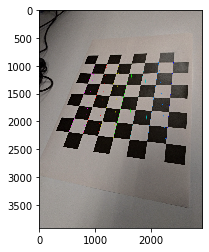

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import camera_calibration_show_extrinsics as show
from PIL import Image
corner_x = 7
corner_y = 7
objp = np.zeros((corner_x*corner_y,3), np.float32)
objp[:,:2] = np.mgrid[0:corner_x, 0:corner_y].T.reshape(-1,2)

objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('data/*.jpg')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray)

    #Find the chessboard corners
    print('find the chessboard corners of',fname)
    ret, corners = cv2.findChessboardCorners(gray, (corner_x,corner_y), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (corner_x,corner_y), corners, ret)
        plt.imshow(img)

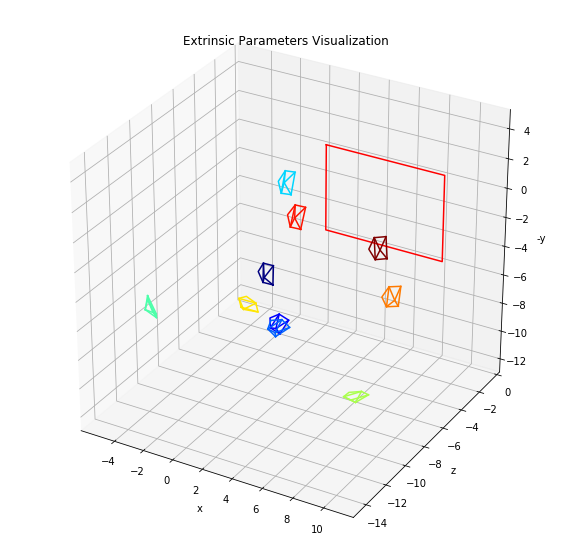

In [11]:
def Normalize(X):
    #normalize the x,y coordinate of image and object points
    mean_x, mean_y = np.mean(X,axis=0)
    var_x, var_y = np.var(X,axis=0)
    s_x, s_y = (2/var_x)**0.5, (2/var_y)**0.5
    N = np.zeros((3,3))
    # N is the normalization matrix
    N[0,0],N[1,1],N[2,2] = s_x, s_y, 1
    N[0,2],N[1,2] = -1*s_x*mean_x, -1*s_y*mean_y
    homo_X = np.append(X,np.ones((X.shape[0],1)),axis=1)
    Norm_X = N.dot(homo_X.T).T
    # return normalized non-homogenous coordinate and the normalization matrix
    return Norm_X[:,:2]/Norm_X[:,[-1]], N
def Estimate_homography(objpts,imgpts):
    global corner_x, corner_y
    H = np.empty((3, 3), dtype=float)
    M = np.empty((corner_x*corner_y*2, 9), dtype=float)
    #using DLT to find homography of each image by image and object points
    for j, (imgp, objp) in enumerate(zip(imgpts, objpts)):
        x, y = imgp
        X, Y = objp
        M[j*2, :] = [-X, -Y, -1, 0, 0, 0, x*X, x*Y, x]
        M[j*2+1, :] = [0, 0, 0, -X, -Y, -1, y*X, y*Y, y]
    # H is the last column of v in svd decomposition
    u, s, v = np.linalg.svd(M)
    H = v[np.argmin(s)].reshape(3, 3)
    H /= H[-1, -1]
    return H

num_of_point = 49
Homography = []
objp = [np.delete(p,2,1) for p in objpoints] # transform obj points into 2D
imgp = np.asarray(imgpoints).reshape(10,49,2)
for i in range(10):
    norm_objp, Nx = Normalize(objp[i]) # normalize obj points
    norm_imgp, Nu = Normalize(imgp[i]) # normalize img points
    norm_H = Estimate_homography(norm_objp,norm_imgp) #estimate homography
    H = np.matmul(np.linalg.inv(Nu),np.matmul(norm_H,Nx))
    Homography.append(H)

num_of_plane = 10
V = np.zeros((num_of_plane*2,6))
for i, homography in enumerate(Homography):
    if i == num_of_plane:
        break
    h1 = homography[:,0]
    h2 = homography[:,1]
    V12 = np.asarray([h1[0]*h2[0], h1[0]*h2[1]+h1[1]*h2[0], h1[1]*h2[1],
           h1[2]*h2[0]+h1[0]*h2[2],h1[2]*h2[1]+h1[1]*h2[2], h1[2]*h2[2]])
    V11 = np.asarray([h1[0]*h1[0], h1[0]*h1[1]+h1[1]*h1[0], h1[1]*h1[1],
           h1[2]*h1[0]+h1[0]*h1[2],h1[2]*h1[1]+h1[1]*h1[2], h1[2]*h1[2]])
    V22 = np.asarray([h2[0]*h2[0], h2[0]*h2[1]+h2[1]*h2[0], h2[1]*h2[1],
           h2[2]*h2[0]+h2[0]*h2[2],h2[2]*h2[1]+h2[1]*h2[2], h2[2]*h2[2]])
    V[2*i] = V12
    V[2*i+1] = V11 - V22
# using same method as homography to find optimal solution of b
U2, D2, V2 = np.linalg.svd(V)
b = V2[-1]
B = np.zeros((3,3))
# reconstruct B(3x3) by b(6x1)
B[0][0], B[0][1], B[1][1], B[0][2], B[1][2], B[2][2] = b[0:6]
B[1][0], B[2][0], B[2][1] = B[0][1], B[0][2], B[1][2]
try:
    # use cholesky decomposition of B to find intrinsic matrix K
    K_inv = np.transpose(np.linalg.cholesky(B)) #inverse of intrinsic matrix
    K = np.linalg.inv(K_inv)
except:
    # but if B is not positive definite, use the close form to find K instead
    print("B is not positive definite.")
    v0 = (B[0][1]*B[0][2]-B[0][0]*B[1][2])/(B[0][0]*B[1][1]-B[0][1]**2)
    ld = B[2][2]-(B[0][2]**2+v0*(B[0][1]*B[0][2]-B[0][0]*B[1][2]))/B[0][0]
    al = (ld/B[0][0])**0.5
    bt = (ld*B[0][0]/(B[0][0]*B[1][1]-B[0][1]**2))**0.5
    gm = -1*B[0][1]*al*al*bt/ld
    u0 = gm*v0/bt - B[0][2]*al*al/ld
    K = np.zeros((3,3))
    K[0,0],K[0,1],K[0,2],K[1,1],K[1,2],K[2,2]=al, gm, u0, bt, v0, 1
    K_inv = np.linalg.inv(K)
    
Extrinsics = np.zeros((num_of_plane,3,4))
# calculate extrinsic matrix by homography and intrinsic matrix
for i, homography in enumerate(Homography):
    E = np.matmul(K_inv,homography) # lambda*K^-1 * H = [r1, r2, t]
    E = E / (E[0][0]**2 + E[1][0]**2 + E[2][0]**2)**0.5 # = [r1, r2, t]
    r1, r2, t = E[:,0], E[:,1], E[:,2]
    r3 = np.cross(r1,r2)
    Extrinsics[i][:,0],Extrinsics[i][:,1],Extrinsics[i][:,2],Extrinsics[i][:,3]=r1,r2,r3,t
# draw the extrinsic visualization
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
# camera setting
camera_matrix = K # intrinsic matrix
cam_width = 0.064/0.1
cam_height = 0.032/0.1
scale_focal = 1600
# chess board setting
board_width = 8
board_height = 6
square_size = 1
# display
# True -> fix board, moving cameras
# False -> fix camera, moving boards
min_values, max_values = show.draw_camera_boards(ax, camera_matrix, cam_width, cam_height,
                                                scale_focal, Extrinsics, board_width,
                                                board_height, square_size, True)
X_min = min_values[0]
X_max = max_values[0]
Y_min = min_values[1]
Y_max = max_values[1]
Z_min = min_values[2]
Z_max = max_values[2]
max_range = np.array([X_max-X_min, Y_max-Y_min, Z_max-Z_min]).max() / 2.0

mid_x = (X_max+X_min) * 0.5
mid_y = (Y_max+Y_min) * 0.5
mid_z = (Z_max+Z_min) * 0.5

ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, 0)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_zlabel('-y')
ax.set_title('Extrinsic Parameters Visualization')
plt.show()